In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the neural network
class ODENet(tf.keras.Model):
    def __init__(self):
        super(ODENet, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='sigmoid')
        self.dense2 = tf.keras.layers.Dense(50, activation='sigmoid')
        self.dense3 = tf.keras.layers.Dense(1, activation='linear')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

model = ODENet()

# Central difference for second derivative
def second_derivative(y, h=0.01):
    d2y = (y[2:] - 2*y[1:-1] + y[:-2]) / h**2
    return d2y

# Loss function
def loss_fn(model, x, f, y0, y1, h=0.01):
    y = model(x)
    d2y_approx = second_derivative(y, h)
    d2y_true = f(x[1:-1])
    loss = tf.reduce_mean(tf.square(d2y_approx - d2y_true))
    loss += tf.square(model(tf.constant([[0.0]])) - y0)
    loss += tf.square(model(tf.constant([[1.0]])) - y1)
    return loss

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Train the model
def train_step(model, x, f, y0, y1, h=0.01):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x, f, y0, y1, h)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

# Define f(x)
def f(x):
    return x

# Define your boundary conditions here:
b = 0.0
a = 1.0

y0 = tf.constant([[b]])
y1 = tf.constant([[a]])

# Increase the number of points for better approximation of the second derivative
x_samples = tf.convert_to_tensor(np.linspace(0, 1, 102).reshape(-1, 1), dtype=tf.float32)

# Once trained, you can use `model.predict` to solve the ODE at any given x value.



Step: 0, Loss: [[0.9026057]]
Step: 1000, Loss: [[9.977852e-06]]
Step: 2000, Loss: [[6.9948175e-05]]
Step: 3000, Loss: [[2.4562989e-05]]
Step: 4000, Loss: [[7.397022e-05]]
Step: 5000, Loss: [[6.4091832e-06]]
Step: 6000, Loss: [[7.5740572e-06]]
Step: 7000, Loss: [[2.262263e-05]]
Step: 8000, Loss: [[6.9997106e-05]]
Step: 9000, Loss: [[1.4904611e-05]]
16/16 [==============================] - 0s 553us/step


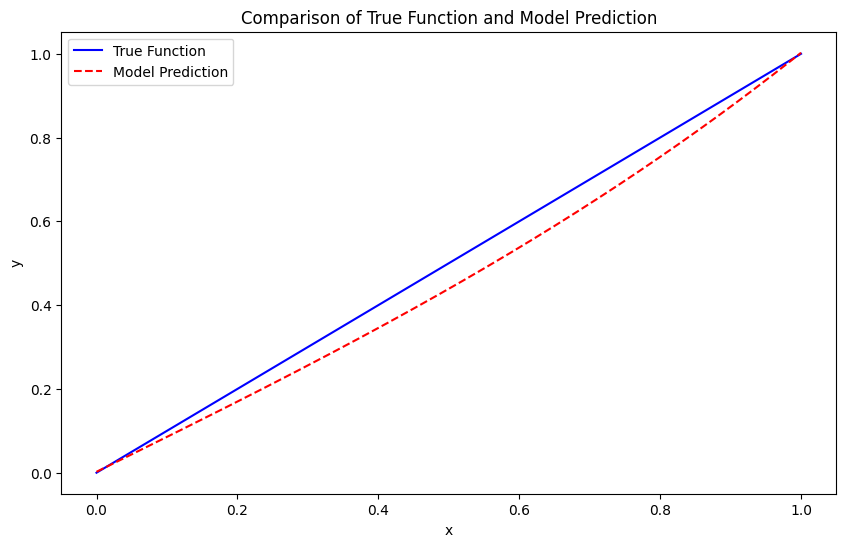

In [10]:
x_samples = tf.convert_to_tensor(np.linspace(0, 1, 102).reshape(-1, 1), dtype=tf.float32)
for step in range(10000):
    loss = train_step(model, x_samples, f, y0, y1)
    if step % 1000 == 0:
        print(f"Step: {step}, Loss: {loss.numpy()}")

# Visualization
x_test = np.linspace(0, 1, 500).reshape(-1, 1)
y_true = f(x_test)
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='True Function', color='blue')
plt.plot(x_test, y_pred, label='Model Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of True Function and Model Prediction')
plt.show()

#y'' = y , y(0)=0, y(1)=1
